# 🌍 Seismic Imaging Course – 2025 Edition
### Numerical Modeling & Inversion (4/4)
**Professor:** Nicola Bienati

**Author:** Felipe Rincón  
*PhD Student in Geophysics*  
📧 felipe.rincon@phd.unipi.it  

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_30208/3773075480.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


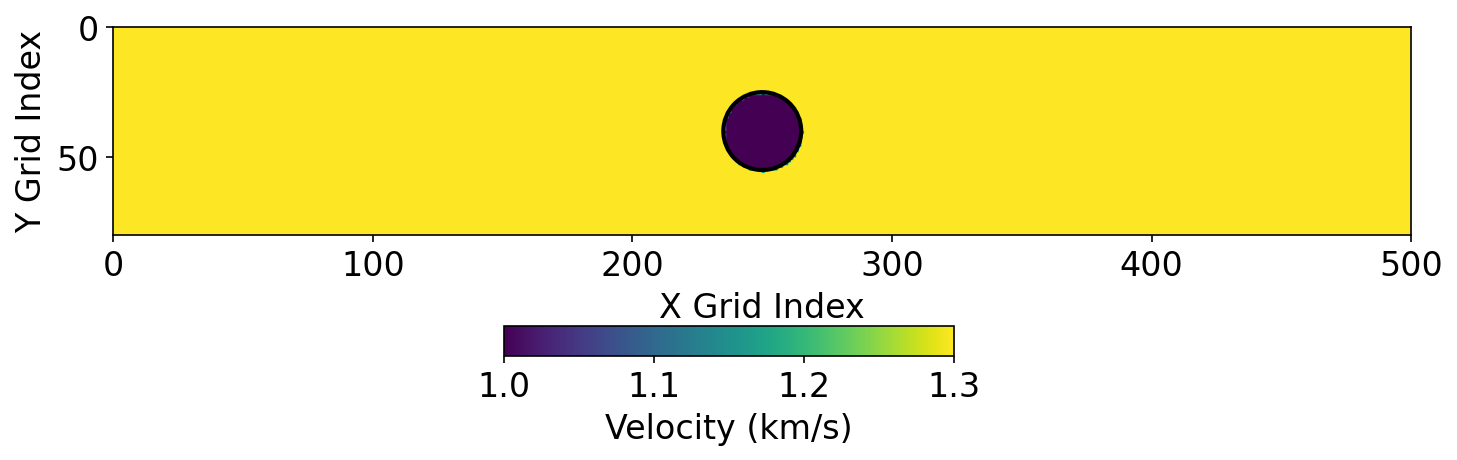

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seismic_utils import (
    generate_source_locations,
    generate_receiver_coordinates,
    plot_shotrecord2,
    compute_residual,
    fwi_gradient,
    plot_velocity_clim,
    Model,
    configuration,
    AcquisitionGeometry,
    AcousticWaveSolver,
    mmax,
    compute_update,
    plot_shotrecord_array
)


# Lets assume a true model in the subsurface
nx, nz = 500, 80
v0 = 1.3
velocity = np.full((nz, nx), v0, dtype=float)
cx, cz = nx // 2, nz // 2
radius = 15 #in grid points
perturbation = 0.3

for z in range(nz):
    for x in range(nx):
        if (x - cx)**2 + (z - cz)**2 <= radius**2:
            velocity[z, x] -= perturbation

fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(velocity, cmap="viridis", origin="lower", extent=[0, nx, 0, nz])
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
circle = plt.Circle((cx, cz), radius, color='black', fill=False, linewidth=2)
plt.gca().add_patch(circle)
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])

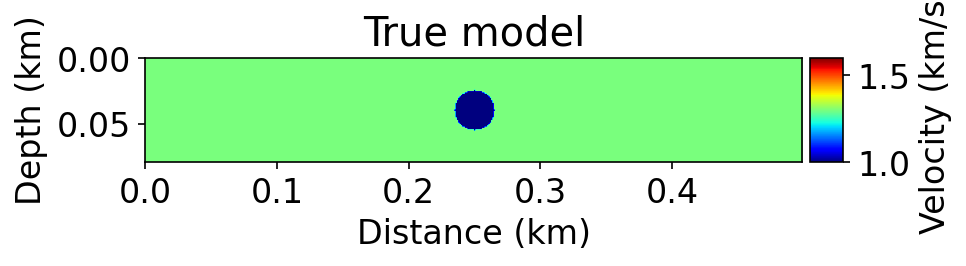

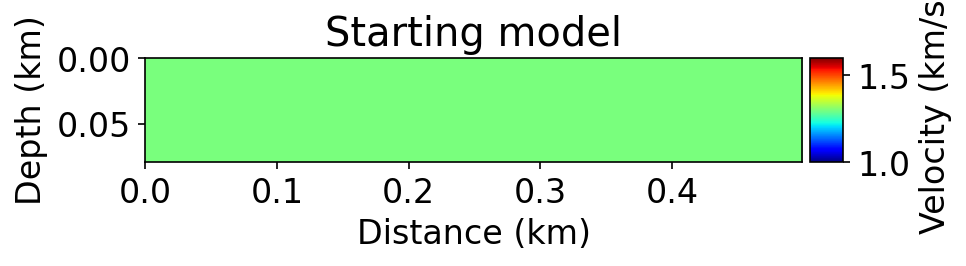

In [2]:
configuration['log-level'] = 'WARNING'
nshots = 10  # Number of shots
nreceivers = 300  # Number of receivers
fwi_iterations = 20  # Number of iterations

# Define true and initial model
shape = (500, 80)  # Number of grid point (nx, nz)
spacing = (1, 1) #in meters
origin = (0., 0.) 

v=np.transpose(velocity)
nbl=20
true_model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(true_model, vmin=v0-perturbation, vmax=v0+perturbation, name="True model", cmap="jet")

#create an starting model
v2=np.ones(shape)*v0
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(start_model, vmin=v0-perturbation, vmax=v0+perturbation, name="Starting model", cmap="jet")

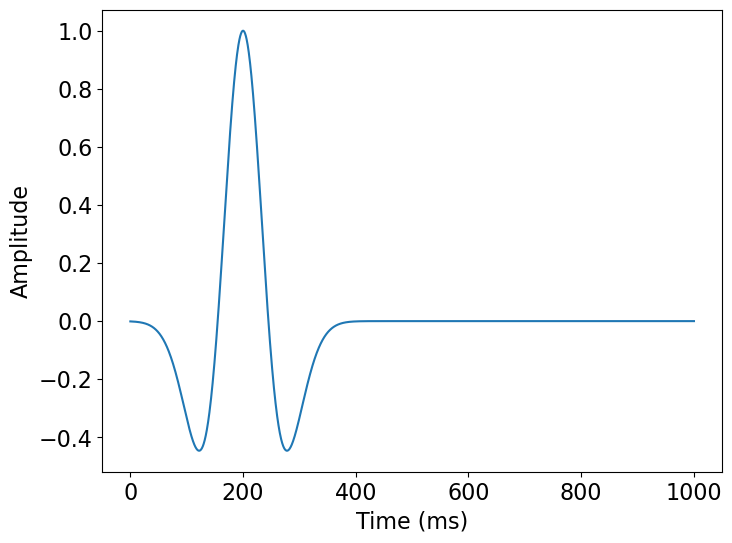

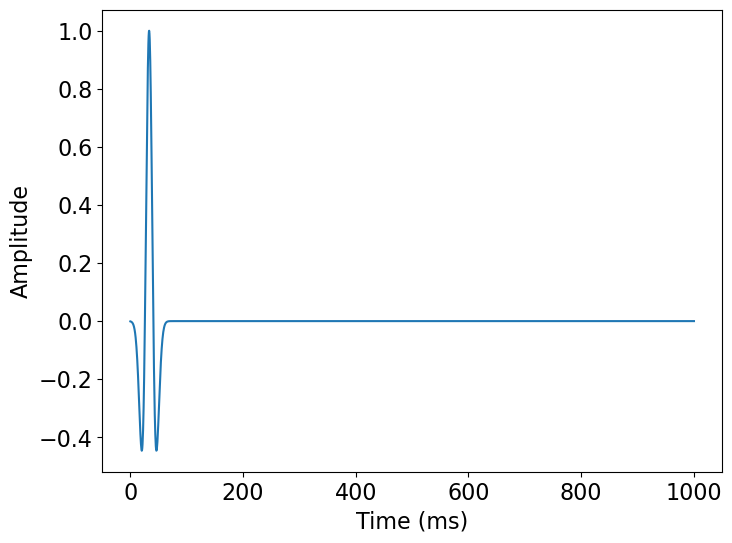

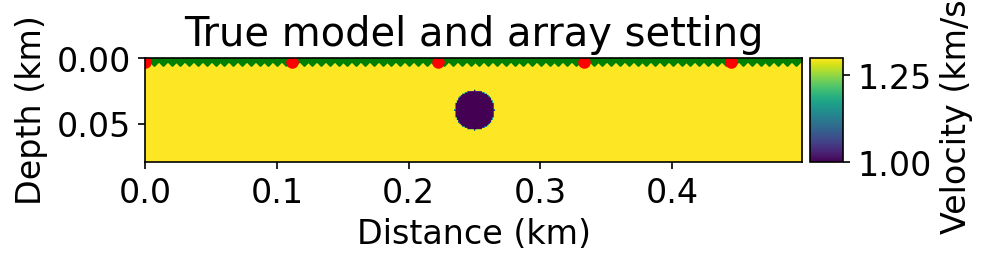

In [3]:
# Define acquisition geometry
t0 = 0
time = 1000.0
dt1 = 0.005 #KHz which means 5 Hz
dt2 = 0.03 #KHz which means 10 Hz

case_src=1
src_coordinates = generate_source_locations(case=case_src, nshots=10)

case_rcv=1
rec_coordinates = generate_receiver_coordinates(case=case_rcv, nreceivers=nreceivers, domain_size=true_model.domain_size)


geometry1 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt1, src_type='Ricker')
geometry1.src.show()

geometry2 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt2, src_type='Ricker')
geometry2.src.show()

plot_velocity_clim(true_model,vmin=v0-perturbation, vmax=v0, name="True model and array setting", cmap="viridis", source=geometry1.src_positions,receiver=geometry1.rec_positions[::4, :])

In [4]:
# simulate the low and high frequency true and initial data
solver1 = AcousticWaveSolver(true_model, geometry1, space_order=4)
true_data1, _, _ = solver1.forward(vp=true_model.vp)
initial_data1, _, _ = solver1.forward(vp=start_model.vp)

solver2 = AcousticWaveSolver(true_model, geometry2, space_order=4)
true_data2, _, _ = solver2.forward(vp=true_model.vp)
initial_data2, _, _ = solver2.forward(vp=start_model.vp)

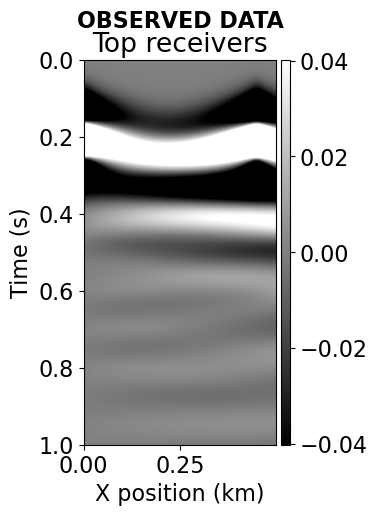

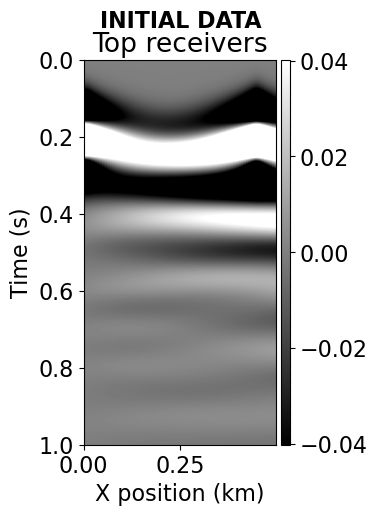

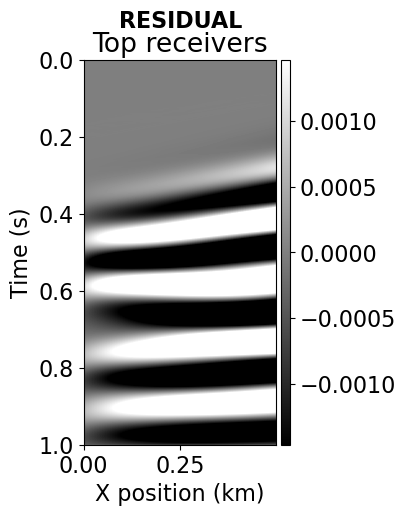

In [5]:
plot_shotrecord_array(true_data1.data, true_model, t0, time, case_rcv, colorbar=True,name='OBSERVED DATA')
plot_shotrecord_array(initial_data1.data, true_model, t0, time, case_rcv, colorbar=True,name='INITIAL DATA')
plot_shotrecord_array(initial_data1.data - true_data1.data, true_model, t0, time, case_rcv, colorbar=True,name='RESIDUAL')


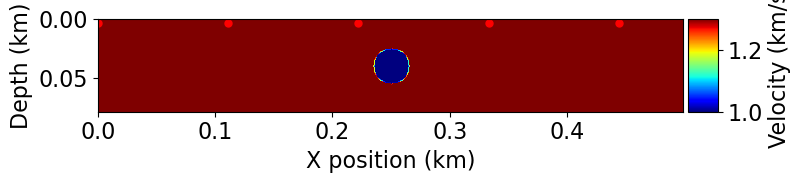

In [6]:
model=true_model

scale = np.max(true_data1.data) / 10.
extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
            1e-3*time, t0]

num_plots = len(str(case_rcv))
rows = 1
cols = num_plots

rec=true_data1.data

mult = len(str(case_src))
source_locations = generate_source_locations(case=case_src,nshots=nshots)

from examples.seismic import plot_velocity
plot_velocity(true_model, source=source_locations)

# #compute the gradient
# ff, update = fwi_gradient(vp_in=start_model.vp,true_model=true_model, geometry=geometry1, nshots=nshots,source_locations=source_locations,solver=solver1, mult=mult)
# a=-update.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
# b1=(true_model.vp.data-start_model.vp.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
# alpha = .5 / mmax(update)
# c1=(start_model.vp.data + alpha*update.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]


In [7]:
# Run this part only if you want to compute the first gradient. Then comment and run everything again if you want to run the inversions.

#  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# im1 = axes[0].imshow(np.transpose(b1), vmin=-0.1, vmax=0.1, cmap="jet")
# axes[0].set_title('What should be updated?')
# axes[0].set_xlabel('Y Grid Index')
# axes[0].set_ylabel('X Grid Index')
# im2 = axes[1].imshow(np.transpose(c1), cmap="jet")
# axes[1].set_title('What is the gradient doing @5Hz?')
# axes[1].set_xlabel('X Grid Index')
# plt.tight_layout()
# plt.savefig("grad_@5hz.pdf", format='pdf', dpi=300)
# plt.show()

# model=true_model

# scale = np.max(true_data2.data) / 10.
# extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
#             1e-3*time, t0]

# num_plots = len(str(case_rcv))
# rows = 1
# cols = num_plots

# rec=true_data2.data

# mult = len(str(case_src))
# source_locations = generate_source_locations(case=case_src,nshots=nshots)

# from examples.seismic import plot_velocity
# plot_velocity(true_model, source=source_locations)

# #compute the gradient
# ff, update = fwi_gradient(vp_in=start_model.vp,true_model=true_model, geometry=geometry2, nshots=nshots,source_locations=source_locations,solver=solver2, mult=mult)
# a=-update.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
# b2=(true_model.vp.data-start_model.vp.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
# alpha = .5 / mmax(update)
# c2=(start_model.vp.data + alpha*update.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# im1 = axes[0].imshow(np.transpose(b2), vmin=-0.1, vmax=0.1, cmap="jet")
# axes[0].set_title('What should be updated?')
# axes[0].set_xlabel('Y Grid Index')
# axes[0].set_ylabel('X Grid Index')
# im2 = axes[1].imshow(np.transpose(c2), cmap="jet")
# axes[1].set_title('What is the gradient doing @30Hz?')
# axes[1].set_xlabel('X Grid Index')
# plt.tight_layout()
# plt.savefig("grad_@30hz.pdf", format='pdf', dpi=300)
# plt.show()

# Low frequency inversion

In [8]:
from devito import Min, Max, mmax
from devito import Operator, Eq

# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=0.8, vmax=1.3):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

# Run FWI with gradient descent
history1 = np.zeros((fwi_iterations, 1))
predicted_model1=np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations))
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
temp_inv_mod = start_model
for i in range(0, fwi_iterations):
    phi1, direction1 = fwi_gradient(
        vp_in=temp_inv_mod.vp,
        true_model=true_model,
        geometry=geometry1, #5 Hz
        nshots=nshots,
        source_locations=source_locations,
        solver=solver1, #5 Hz
        mult=mult
    )

    history1[i] = phi1
    alpha = .005 / mmax(direction1)
    update_with_box(temp_inv_mod.vp, alpha, direction1)
    predicted_model1[:, :, i] = np.asarray(temp_inv_mod.vp.data)
    print("Objective value is %.6f at iteration %d" % (phi1, i+1))

# Reset model for the 30 Hz inversion
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")

Objective value is 54.388624 at iteration 1
Objective value is 27.176901 at iteration 2
Objective value is 12.441389 at iteration 3
Objective value is 6.417568 at iteration 4
Objective value is 4.251606 at iteration 5
Objective value is 3.327328 at iteration 6
Objective value is 2.778996 at iteration 7
Objective value is 2.382509 at iteration 8
Objective value is 2.079065 at iteration 9
Objective value is 1.836169 at iteration 10
Objective value is 1.636615 at iteration 11
Objective value is 1.469613 at iteration 12
Objective value is 1.328063 at iteration 13
Objective value is 1.206865 at iteration 14
Objective value is 1.102379 at iteration 15
Objective value is 1.011471 at iteration 16
Objective value is 0.931750 at iteration 17
Objective value is 0.861331 at iteration 18
Objective value is 0.798808 at iteration 19
Objective value is 0.742983 at iteration 20


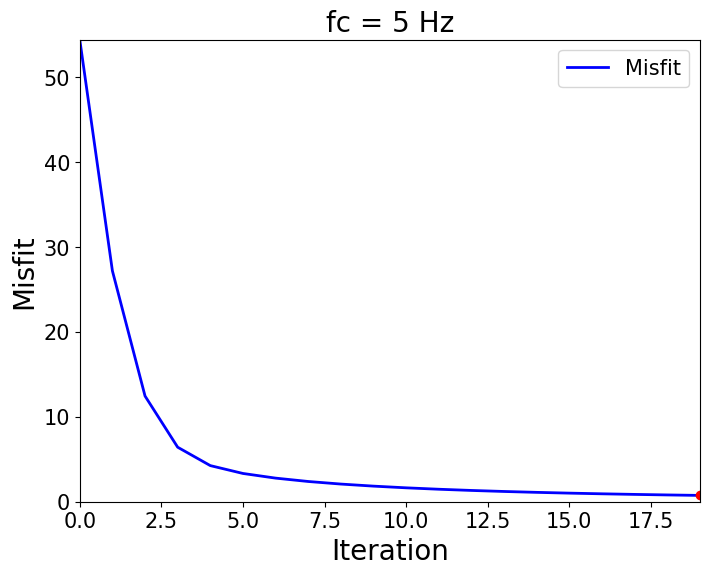

In [9]:
min_index = np.argmin(history1)
min_value = history1[min_index]
max_index = np.argmax(history1[:min_index+1])
max_value = history1[max_index]



plt.figure(figsize=(8, 6))
plt.xlim([0, min_index])
plt.ylim([0, max_value])
plt.plot(history1, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('fc = 5 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_5hz.pdf", format='pdf', dpi=300)

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_30208/3563787489.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


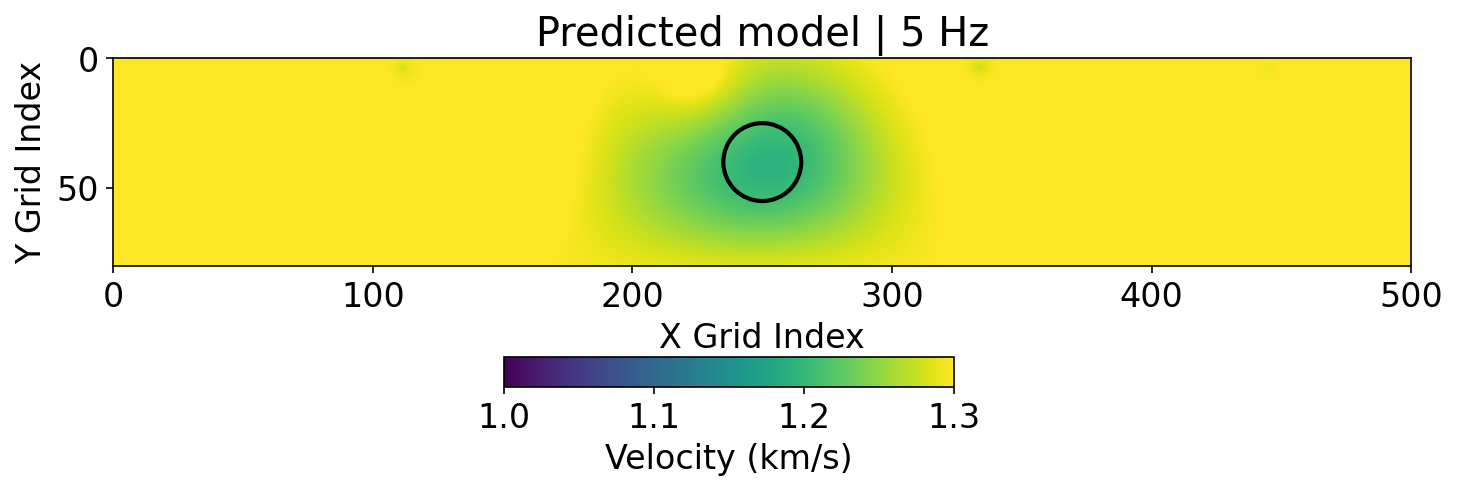

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pred_temp=(predicted_model1[:,:,min_index-1])
pred_temp=(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
pred_model = Model(vp=pred_temp, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")

fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(pred_temp), cmap="viridis", origin="lower", extent=[0, nx, 0, nz],vmin=v0-perturbation, vmax=v0)
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
ax.set_title("Predicted model | 5 Hz")
circle = plt.Circle((cx, cz), radius, color='black', fill=False, linewidth=2)
plt.gca().add_patch(circle)
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("pred_mod_5Hz.pdf", format='pdf', dpi=300)


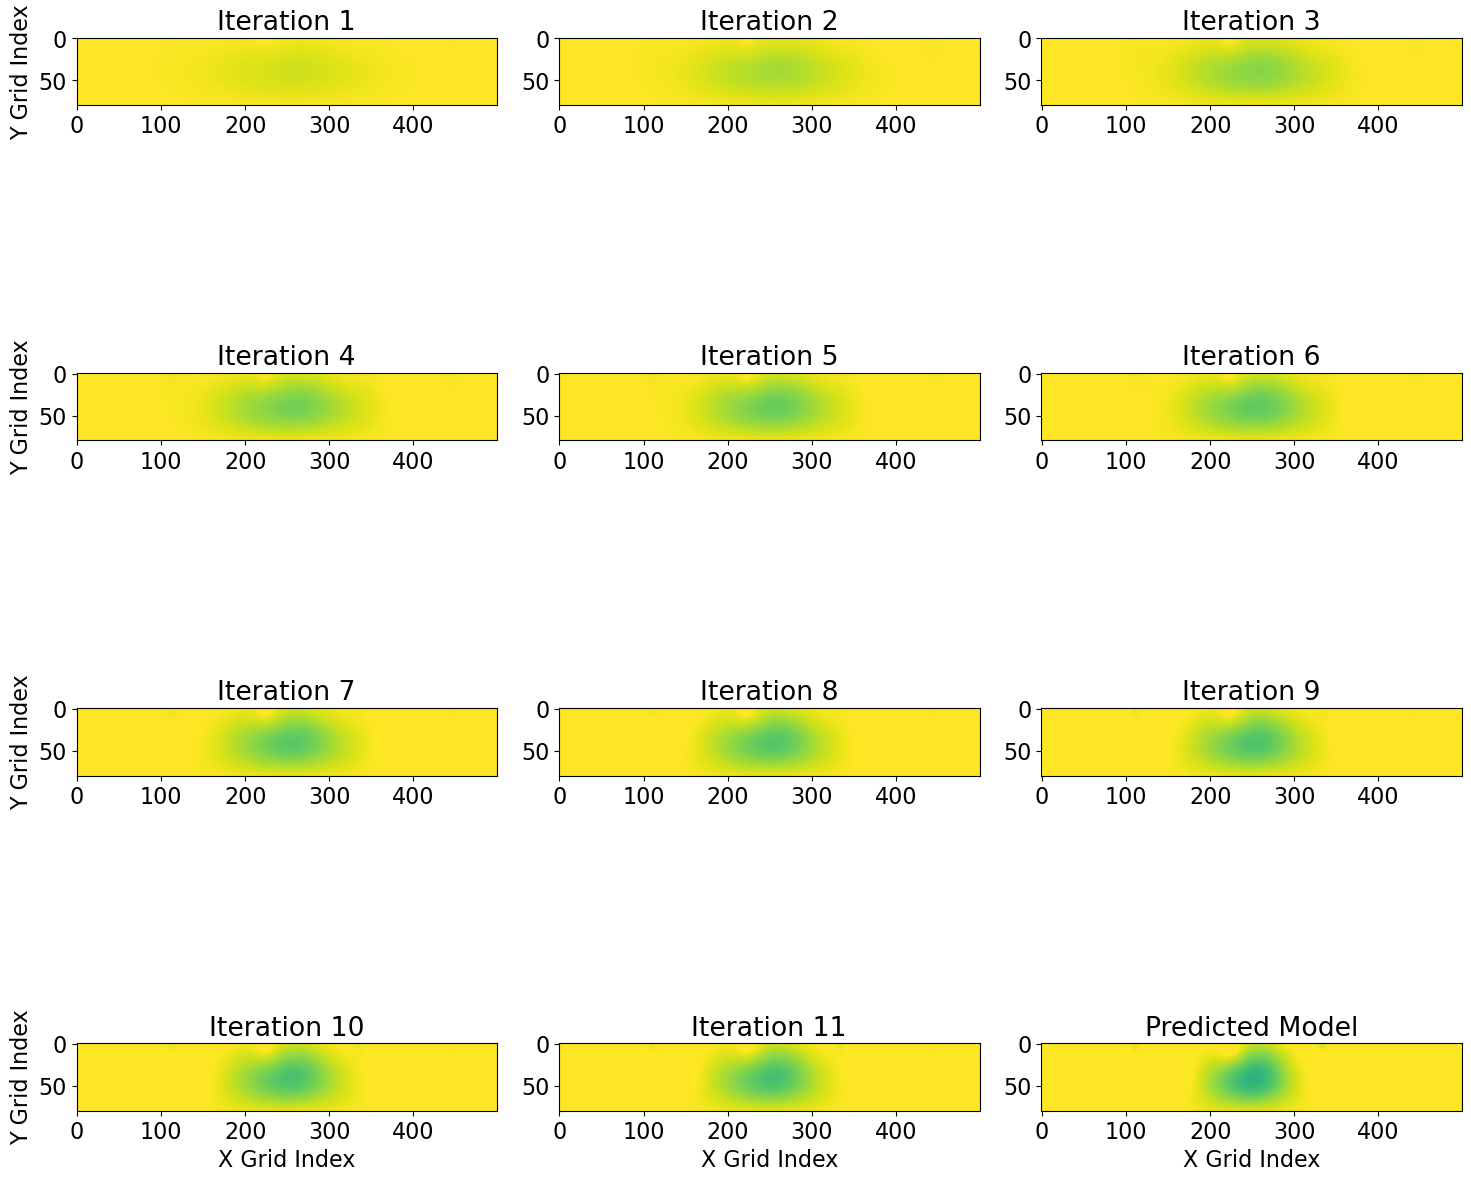

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
start_mod = start_model.vp.data[nbl:shape[0]+nbl, nbl:shape[1]+nbl]

im_starting = axes[0, 0].imshow(start_mod.T, cmap="jet", vmin=v0-perturbation, vmax=v0)
axes[0, 0].set_title('Starting Model')
axes[0, 0].set_ylabel('Y Grid Index') 

for i in range(4):
    for j in range(3):
        iteration = i * 3 + j
        if iteration <= fwi_iterations - 2: 
            pred_temp = predicted_model1[:, :, iteration]
            im = axes[i, j].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
            axes[i, j].set_title(f'Iteration {iteration+1}')
            if i == 3: 
                axes[i, j].set_xlabel('X Grid Index')
            if j == 0 and i != 0: 
                axes[i, j].set_ylabel('Y Grid Index')
        else:
            axes[i, j].axis('off')

if fwi_iterations - 2 >= 12: 
    pred_temp = predicted_model1[:, :, min_index - 1]
    im_predicted = axes[3, 2].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
    axes[3, 2].set_title('Predicted Model')
    axes[3, 2].set_xlabel('X Grid Index')

plt.tight_layout()
plt.show()

# High frequency inversion

In [12]:
#inverting for 30 Hz
# Run FWI with gradient descent
fwi_iterations=11 #it will requre less iterations :p
history2 = np.zeros((fwi_iterations, 1))
predicted_model2=np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations))
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
temp_inv_mod = start_model
for i in range(0, fwi_iterations):
    phi1, direction2 = fwi_gradient(
        vp_in=temp_inv_mod.vp,
        true_model=true_model,
        geometry=geometry2, #30 Hz
        nshots=nshots,
        source_locations=source_locations,
        solver=solver2, #30 Hz
        mult=mult
    )

    history2[i] = phi1
    alpha = .05 / mmax(direction1) #alpha scaling factor is bigger now
    update_with_box(temp_inv_mod.vp, alpha, direction1)
    predicted_model2[:, :, i] = np.asarray(temp_inv_mod.vp.data)
    print("Objective value is %.6f at iteration %d" % (phi1, i+1))

Objective value is 21.402629 at iteration 1
Objective value is 19.257927 at iteration 2
Objective value is 17.183354 at iteration 3
Objective value is 15.221724 at iteration 4
Objective value is 13.423239 at iteration 5
Objective value is 11.846087 at iteration 6
Objective value is 10.556199 at iteration 7
Objective value is 9.626618 at iteration 8
Objective value is 9.136302 at iteration 9
Objective value is 9.168198 at iteration 10
Objective value is 9.806624 at iteration 11


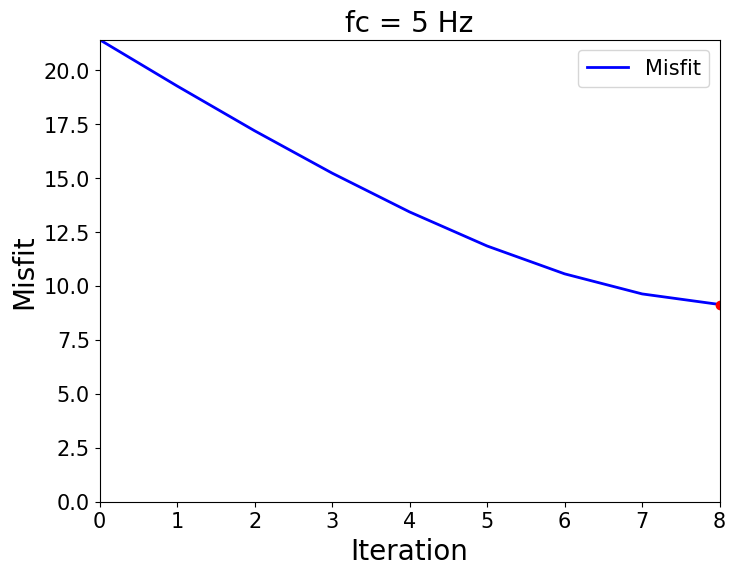

In [13]:
min_index = np.argmin(history2)
min_value = history2[min_index]

max_index = np.argmax(history2[:min_index+1])
max_value = history2[max_index]


plt.figure(figsize=(8, 6))
plt.xlim([0, min_index])
plt.ylim([0, max_value])

plt.plot(history2, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('fc = 5 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_30hz.pdf", format='pdf', dpi=300)

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_30208/4088045354.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


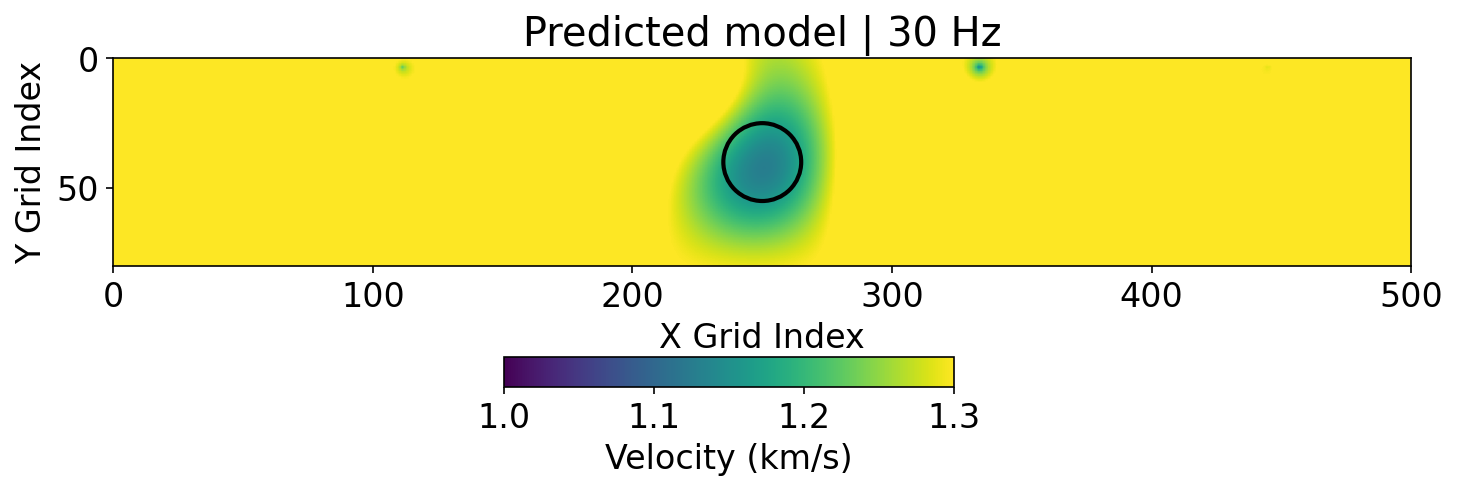

In [14]:
pred_temp=(predicted_model2[:,:,min_index-1])
pred_temp=(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
pred_model = Model(vp=pred_temp, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")

fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(pred_temp), cmap="viridis", origin="lower", extent=[0, nx, 0, nz],vmin=v0-perturbation, vmax=v0)
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
ax.set_title("Predicted model | 30 Hz")
circle = plt.Circle((cx, cz), radius, color='black', fill=False, linewidth=2)
plt.gca().add_patch(circle)
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("pred_mod_30Hz.pdf", format='pdf', dpi=300)


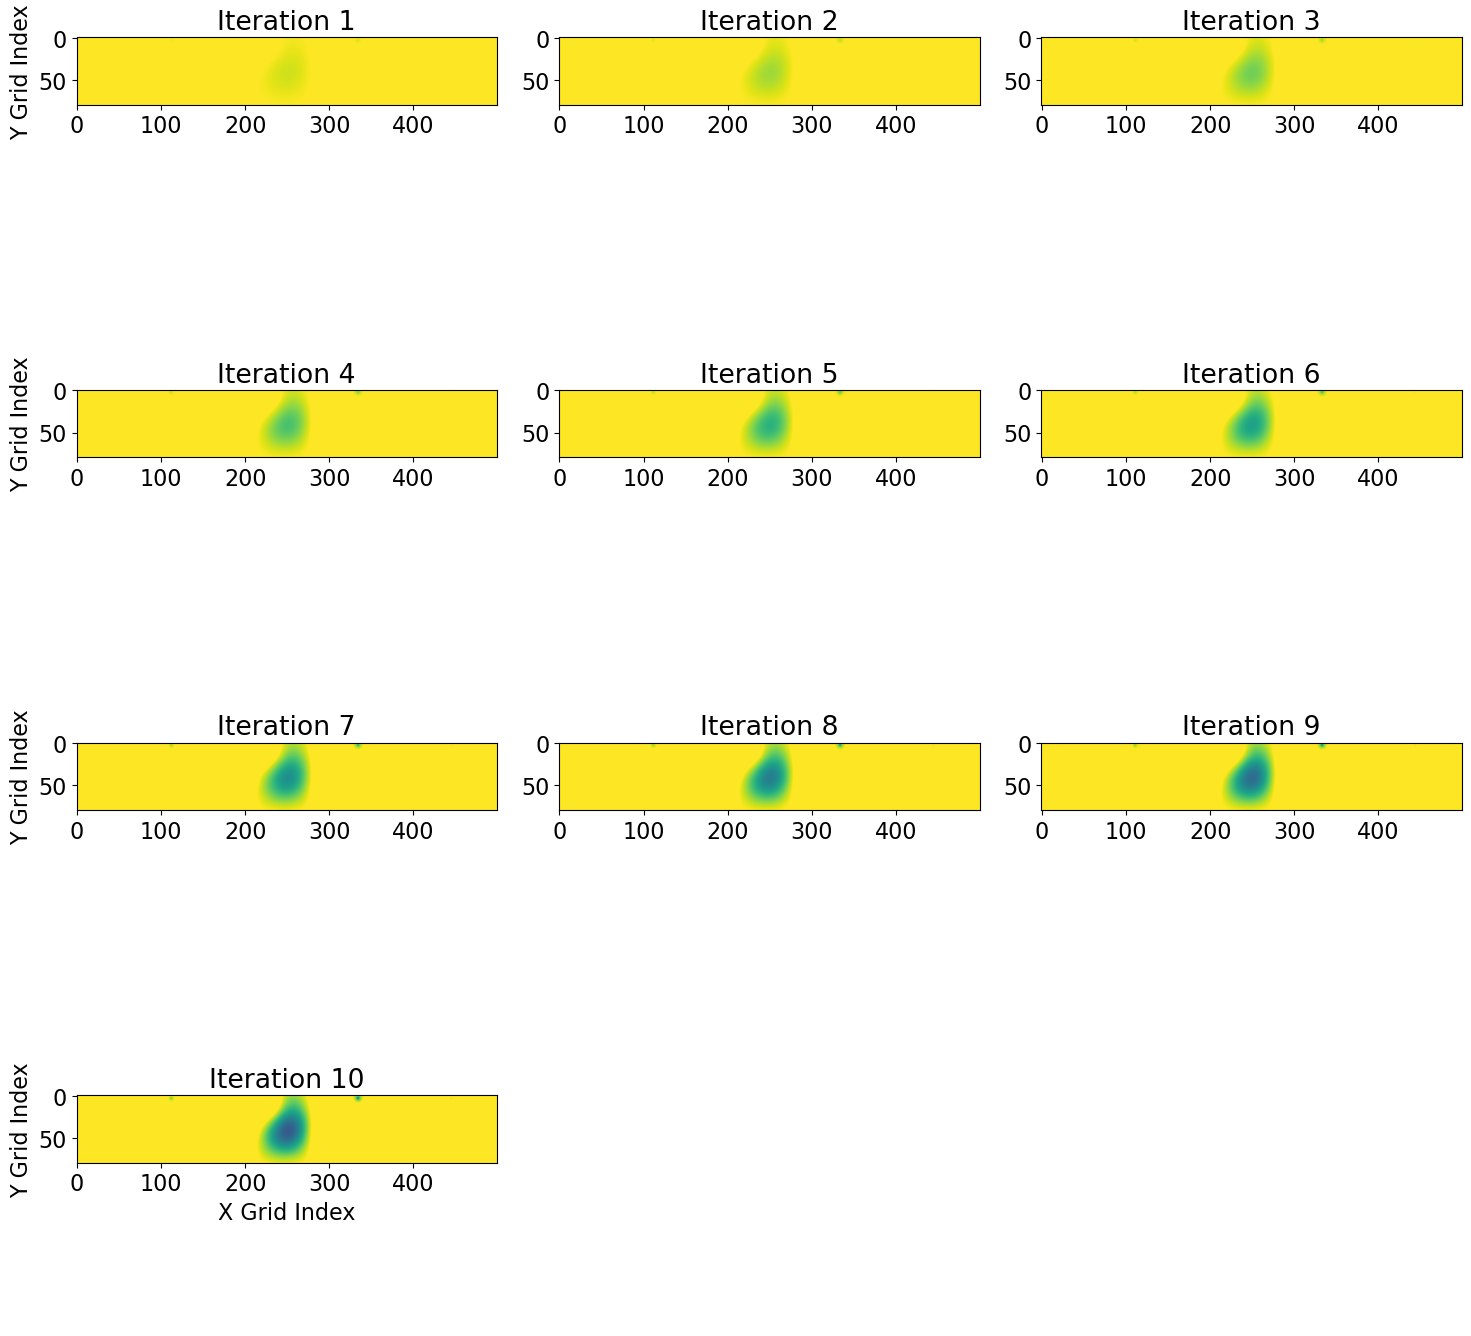

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
start_mod = start_model.vp.data[nbl:shape[0]+nbl, nbl:shape[1]+nbl]

im_starting = axes[0, 0].imshow(start_mod.T, cmap="jet", vmin=v0-perturbation, vmax=v0)
axes[0, 0].set_title('Starting Model')
axes[0, 0].set_ylabel('Y Grid Index') 

for i in range(4):
    for j in range(3):
        iteration = i * 3 + j
        if iteration <= fwi_iterations - 2: 
            pred_temp = predicted_model2[:, :, iteration]
            im = axes[i, j].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
            axes[i, j].set_title(f'Iteration {iteration+1}')
            if i == 3: 
                axes[i, j].set_xlabel('X Grid Index')
            if j == 0 and i != 0: 
                axes[i, j].set_ylabel('Y Grid Index')
        else:
            axes[i, j].axis('off')

if fwi_iterations - 2 >= 12: 
    pred_temp = predicted_model2[:, :, min_index - 1]
    im_predicted = axes[3, 2].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
    axes[3, 2].set_title('Predicted Model')
    axes[3, 2].set_xlabel('X Grid Index')

plt.tight_layout()
plt.show()

# Multi scale inversion

In [16]:
# Run FWI @5Hz
fwi_iterations1=20
fwi_iterations2=20

history1 = np.zeros((fwi_iterations1+fwi_iterations2, 1))
predicted_model1=np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations1+fwi_iterations2))
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
temp_inv_mod = start_model

for i in range(0, fwi_iterations1):
    phi1, direction1 = fwi_gradient(
        vp_in=temp_inv_mod.vp,
        true_model=true_model,
        geometry=geometry1, #5 Hz
        nshots=nshots,
        source_locations=source_locations,
        solver=solver1, #5 Hz
        mult=mult
    )

    history1[i] = phi1
    alpha = .005 / mmax(direction1)
    update_with_box(temp_inv_mod.vp, alpha, direction1)
    predicted_model1[:, :, i] = np.asarray(temp_inv_mod.vp.data)
    print("Objective function @ 5Hz is %.6f at iteration %d" % (phi1, i+1))

Objective function @ 5Hz is 54.388624 at iteration 1
Objective function @ 5Hz is 27.176901 at iteration 2
Objective function @ 5Hz is 12.441389 at iteration 3
Objective function @ 5Hz is 6.417568 at iteration 4
Objective function @ 5Hz is 4.251606 at iteration 5
Objective function @ 5Hz is 3.327328 at iteration 6
Objective function @ 5Hz is 2.778996 at iteration 7
Objective function @ 5Hz is 2.382509 at iteration 8
Objective function @ 5Hz is 2.079065 at iteration 9
Objective function @ 5Hz is 1.836169 at iteration 10
Objective function @ 5Hz is 1.636615 at iteration 11
Objective function @ 5Hz is 1.469613 at iteration 12
Objective function @ 5Hz is 1.328063 at iteration 13
Objective function @ 5Hz is 1.206865 at iteration 14
Objective function @ 5Hz is 1.102379 at iteration 15
Objective function @ 5Hz is 1.011471 at iteration 16
Objective function @ 5Hz is 0.931750 at iteration 17
Objective function @ 5Hz is 0.861331 at iteration 18
Objective function @ 5Hz is 0.798808 at iteration 19

In [17]:
model=true_model
scale = np.max(true_data2.data) / 10.
extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
            1e-3*time, t0]

num_plots = len(str(case_rcv))
rows = 1
cols = num_plots

rec=true_data2.data
mult = len(str(case_src))

#compute the gradient
ff, update = fwi_gradient(vp_in=temp_inv_mod.vp, true_model=true_model, geometry=geometry2, nshots=nshots,source_locations=source_locations,solver=solver2, mult=mult)
a=-update.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
b2=(true_model.vp.data-start_model.vp.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
alpha = .5 / mmax(update)
c2=(start_model.vp.data + alpha*update.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]


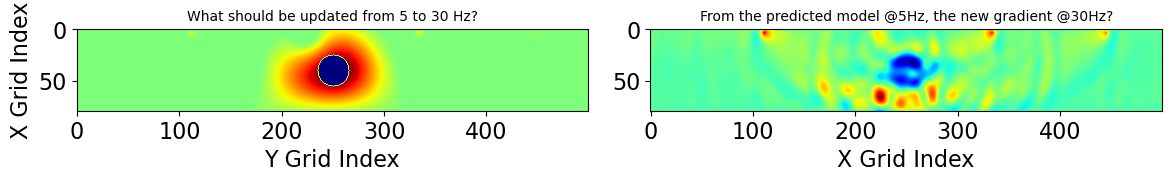

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im1 = axes[0].imshow(np.transpose(b2), vmin=-0.1, vmax=0.1, cmap="jet")
# axes[0].set_title('What should be updated?')
axes[0].set_title('What should be updated from 5 to 30 Hz?', fontsize=10)
axes[0].set_xlabel('Y Grid Index')
axes[0].set_ylabel('X Grid Index')
im2 = axes[1].imshow(np.transpose(c2), cmap="jet")
axes[1].set_title('From the predicted model @5Hz, the new gradient @30Hz?', fontsize=10)
axes[1].set_xlabel('X Grid Index')
plt.tight_layout()
plt.savefig("grad_@5_30hz.pdf", format='pdf', dpi=300)
plt.show()

In [19]:
# Run FWI @30Hz
start_model30Hz = temp_inv_mod
previous_phi = None

for i in range(fwi_iterations2):
    phi2, direction2 = fwi_gradient(
        vp_in=start_model30Hz.vp,
        true_model=true_model,
        geometry=geometry2,
        nshots=nshots,
        source_locations=source_locations,
        solver=solver2,
        mult=mult
    )

    if previous_phi is not None and phi2 > previous_phi:
        print(f"Stopping early at iteration {i} (phi increased: {phi2:.6f} > {previous_phi:.6f})")
        break

    history1[fwi_iterations1 + i] = phi2
    alpha = 0.05 / mmax(direction2) #with an smaller alpha scaling factor?
    update_with_box(start_model30Hz.vp, alpha, direction2)
    predicted_model1[:, :, fwi_iterations1 + i] = np.asarray(start_model30Hz.vp.data)
    print("Objective @ 30Hz is %.6f at iteration %d" % (phi2, fwi_iterations1 + i + 1))

    previous_phi = phi2

Objective @ 30Hz is 15.923525 at iteration 21
Objective @ 30Hz is 9.231023 at iteration 22
Objective @ 30Hz is 5.670747 at iteration 23
Objective @ 30Hz is 3.457458 at iteration 24
Objective @ 30Hz is 2.090703 at iteration 25
Objective @ 30Hz is 1.247450 at iteration 26
Objective @ 30Hz is 0.738005 at iteration 27
Objective @ 30Hz is 0.441911 at iteration 28
Objective @ 30Hz is 0.350336 at iteration 29
Stopping early at iteration 9 (phi increased: 7.263154 > 0.350336)


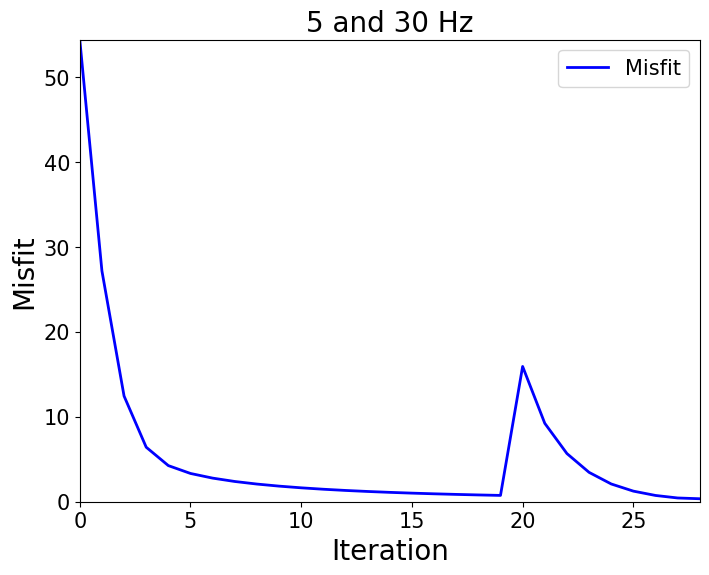

In [20]:
min_index = np.argmin(history1)
min_value = history1[min_index]

max_index = np.argmax(history1[:min_index+1])
max_value = history1[max_index]




plt.figure(figsize=(8, 6))
plt.xlim([0, min_index-1])
plt.ylim([0, max_value])
plt.plot(history1, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('5 and 30 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_5and30hz.pdf", format='pdf', dpi=300)


/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_30208/2293411373.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


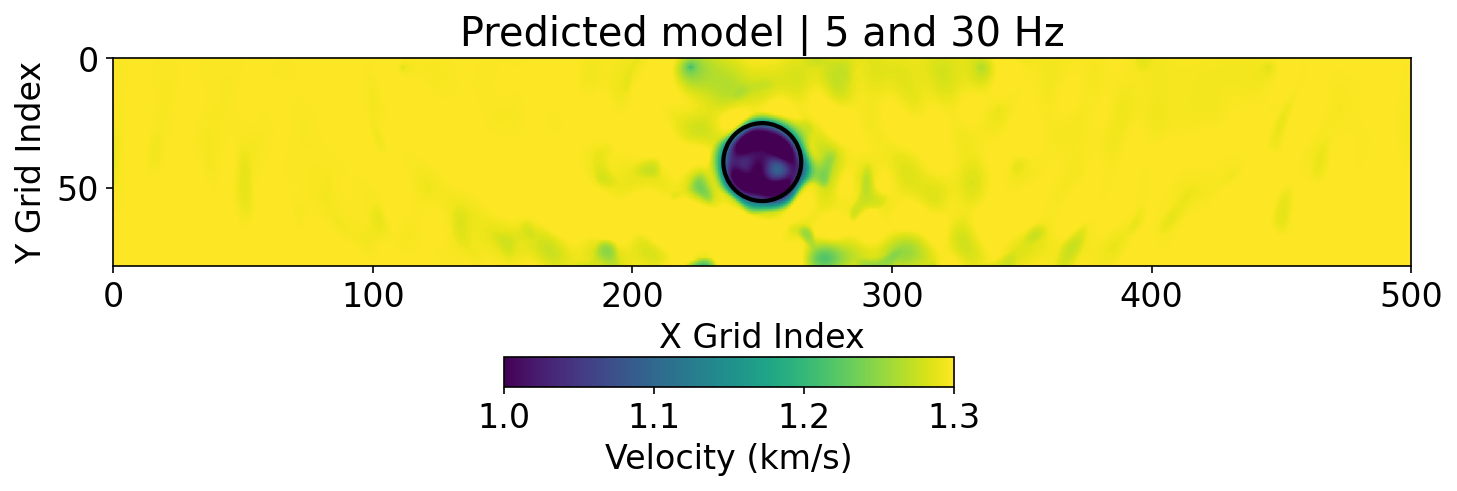

In [21]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
pred_temp=(predicted_model1[:,:,min_index-1])
pred_temp=(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
im = ax.imshow(np.transpose(pred_temp), cmap="viridis", origin="lower", extent=[0, nx, 0, nz],vmin=v0-perturbation, vmax=v0)
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
ax.set_title("Predicted model | 5 and 30 Hz")
circle = plt.Circle((cx, cz), radius, color='black', fill=False, linewidth=2)
plt.gca().add_patch(circle)
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("pred_mod_5_and_30Hz.pdf", format='pdf', dpi=300)
